In [1]:
import gc

from tqdm.notebook import tqdm
from sklearn.decomposition import PCA

from stochman.geodesic import geodesic_minimizing_energy
from stochman import CubicSpline

from utils import *
from circular_utils import *
from plot_utils import *

In [2]:
# Parameters
num_points = 200
r_inner = 0.7  # Inner radius (hole radius)
r_outer = 1.0  # Outer radius

In [63]:
# Generate points
data = generate_annular_points(num_points, r_inner, r_outer)
data_3d = generate_annular_points_3d(num_points, r_inner, r_outer)
grid_size = 100
z_grid, x_lin, y_lin = generate_grid(grid_size=grid_size, device='cpu')

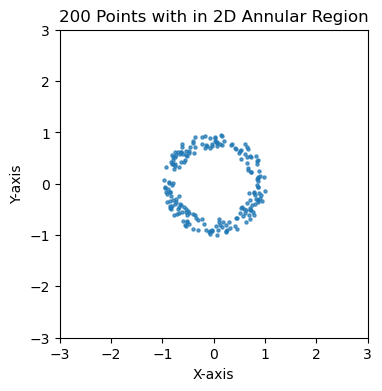

In [64]:
simple_2d_plot(data, num_points)

In [65]:
dm = DensityMetric(data, 0.1)
#dm_energy = lambda _model, _curve: _model.curve_energy(_curve.points())

In [66]:
real_bg = dm.density(z_grid.reshape(-1, 2)).reshape((grid_size, grid_size))
real_bg.shape

torch.Size([100, 100])

In [67]:
num_curves = 30
N, D = data.shape
curve_indices = torch.randint(data.shape[0], (num_curves, 2))  # (num_curves) x 2

In [68]:
batch_c = CubicSpline(begin=data[curve_indices[:, 0]], end=data[curve_indices[:, 1]], num_nodes=20)
geodesic_minimizing_energy(curve=batch_c, manifold=dm, optimizer=torch.optim.RMSprop, max_iter=250)

tensor(False)

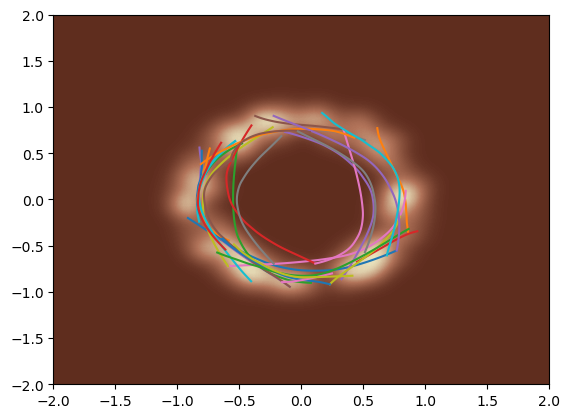

In [69]:
plt.scatter(data[:, 0], data[:, 1], s=1, alpha=0.5)
plt.contourf(x_lin, y_lin, real_bg, levels=100, cmap=rbrown_yellow_cmap)  # Use the custom brownish colormap
batch_c.plot()
plt.show()

In [8]:
batch_c.euclidean_length().mean().item()

1.1244347095489502

In [9]:
data_vae = embed_points_2d_to_100d(data)
train_loader = torch.utils.data.DataLoader(DumbDataset(z=data,y=data_vae), batch_size=64, shuffle=True)
data_vae.shape, data_vae.max(), data_vae.min()

((200, 100), 0.9820594, -0.9824153)

In [10]:
# normalize the data_vae and compute PCA
n_data_vae = (data_vae - data_vae.mean(axis=0)) / data_vae.std(axis=0)
data_vae_3d = PCA(n_components=3).fit_transform(n_data_vae)
# normalize the data_vae_3d
data_vae_3d = (data_vae_3d - data_vae_3d.mean(axis=0)) / data_vae_3d.std(axis=0)

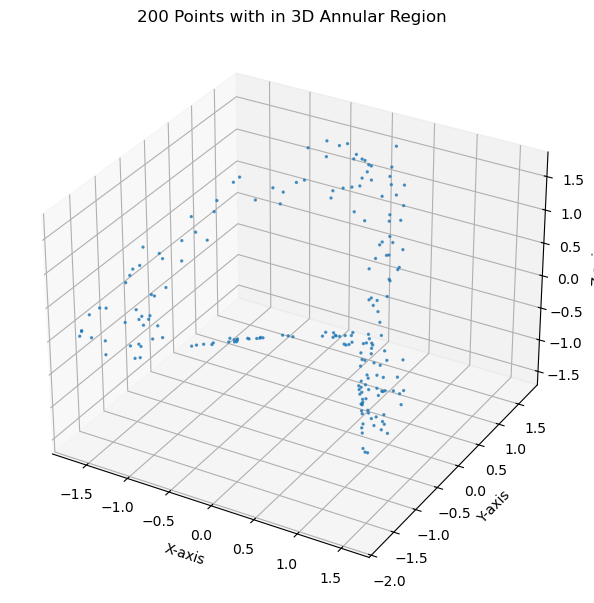

In [11]:
simple_3d_plot(data_vae_3d, num_points)
#interactive_3d_plot(data_vae_3d, num_points)

In [12]:
model = get_decoder()
model.train();

In [13]:
epochs = 40
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [14]:
# write a training loop with tqdm
model.to(device)
losses = []
for epoch in tqdm(range(epochs)):
    for batch in train_loader:
        z, y = batch
        z = z.to(device)
        opt.zero_grad()
        y_hat = model(z)
        loss = torch.nn.functional.mse_loss(y_hat, y.to(device))
        losses.append(loss.item())
        loss.backward()
        opt.step()

100%|██████████| 40/40 [00:01<00:00, 36.64it/s]


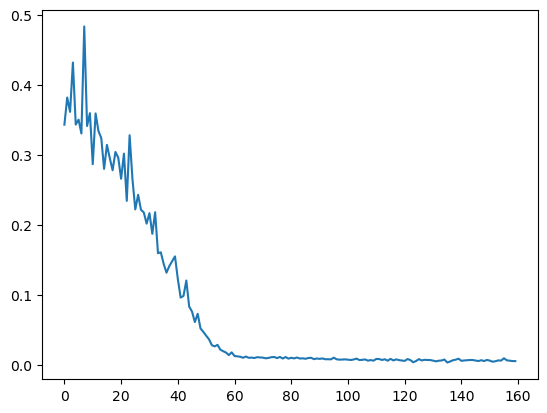

In [15]:
# plot the losses
plt.plot(losses)
plt.show()

In [ ]:
## Put trained models in 'eval' mode
model.eval();

In [ ]:
# compute the jacoian of the model with respect to the data
# Generate input data
#z_grid = torch.FloatTensor(np.random.uniform(-2, 2, size=(1000, 2))).to(device)
#with torch.no_grad():
#    y_hat_grid = model(z_grid)

In [ ]:
gc.collect()

In [20]:
# loop through the grid and compute the jacobian
bg = []
z_grid_list = z_grid.reshape(-1, 2)
for point in tqdm(z_grid_list):
    J = torch.autograd.functional.jacobian(model, point.unsqueeze(0)).squeeze(0).squeeze(1)
    bg.append(torch.sqrt(torch.det((J.T @ J).cpu())).item())
bg = np.array(bg).reshape((grid_size, grid_size))

100%|██████████| 2500/2500 [01:19<00:00, 31.50it/s]


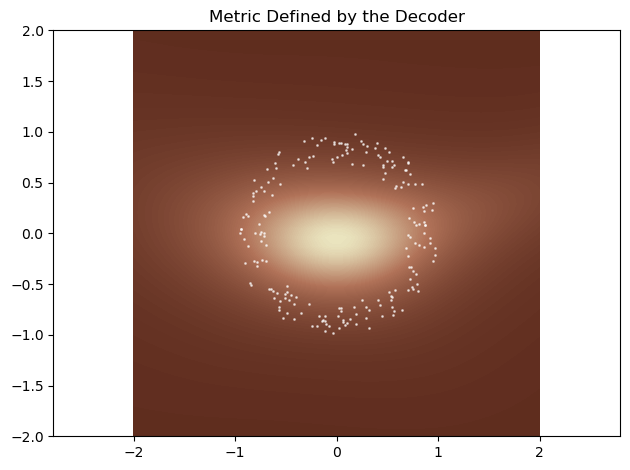

In [21]:
# Plot the magnification factor
plt.figure()
plt.contourf(x_lin, y_lin, bg, levels=100, cmap=rbrown_yellow_cmap)  # Use the custom brownish colormap
plt.scatter(data[:, 0].cpu().numpy(), data[:, 1].cpu().numpy(), s=1, alpha=0.6,c='w')
plt.title("Metric Defined by the Decoder")
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.axis('equal')
plt.tight_layout()
plt.show()

In [22]:
from stochman.manifold import EmbeddedManifold

class DecoderInducedManifold(EmbeddedManifold):
    def __init__(self, decoder):
        self.decoder = decoder 
    
    def embed(self, c, jacobian = False):
        if jacobian:
            return self.decoder(c), None
        else:
            return self.decoder(c)

In [26]:
model.to('cpu')
M = DecoderInducedManifold(model)

In [27]:
c, _ = M.connecting_geodesic(p0=data[curve_indices[:, 0]], p1=data[curve_indices[:, 1]])

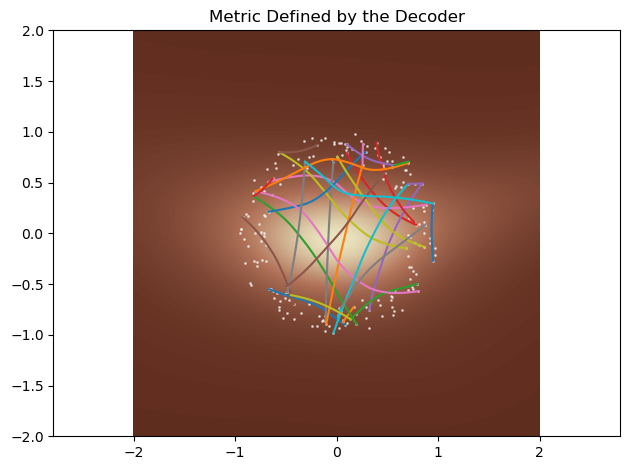

In [29]:
# Plot the magnification factor
plt.figure()
plt.contourf(x_lin, y_lin, bg, levels=100, cmap=rbrown_yellow_cmap)  # Use the custom brownish colormap
plt.scatter(data[:, 0].cpu().numpy(), data[:, 1].cpu().numpy(), s=1, alpha=0.6,c='w')
c.plot()
plt.title("Metric Defined by the Decoder")
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.axis('equal')
plt.tight_layout()
plt.show()

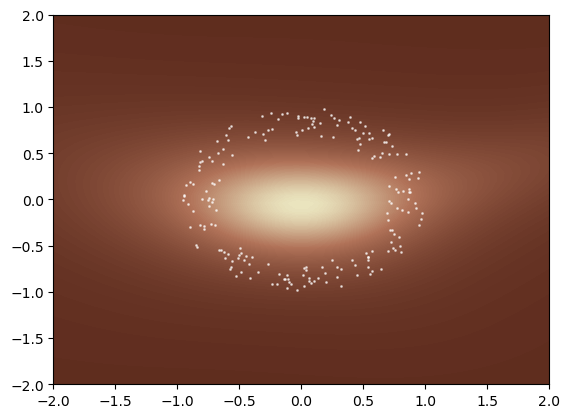

In [35]:
plt.contourf(x_lin, y_lin, bg, levels=100, cmap=rbrown_yellow_cmap)  # Use the custom brownish colormap
plt.scatter(data[:, 0].cpu().numpy(), data[:, 1].cpu().numpy(), s=1, alpha=0.6,c='w')
batch_c = CubicSpline(begin=data[curve_indices[:, 0]], end=data[curve_indices[:, 0]], num_nodes=20)
geodesic_minimizing_energy(curve=batch_c, manifold=dm, optimizer=torch.optim.RMSprop, max_iter=200)
batch_c.plot()
plt.show()